NEURAL STYLE TRANSFER

- IMPLEMENT A NEURAL STYLE TRANSFER MODEL TO APPLY ARTISTIC STYLES TO PHOTOGRAPHS
- DELIVERABLE: A PYTHON SCRIPT OR NOTEBOOK WITH EXAMPLES OF STYLED IMAGES.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

Iteration 0/100, Loss: 1426007936.0000
Iteration 10/100, Loss: 106811816.0000
Iteration 20/100, Loss: 37878800.0000
Iteration 30/100, Loss: 22077082.0000
Iteration 40/100, Loss: 15925517.0000
Iteration 50/100, Loss: 12878038.0000
Iteration 60/100, Loss: 11021422.0000
Iteration 70/100, Loss: 9800832.0000
Iteration 80/100, Loss: 8924436.0000
Iteration 90/100, Loss: 8258557.0000


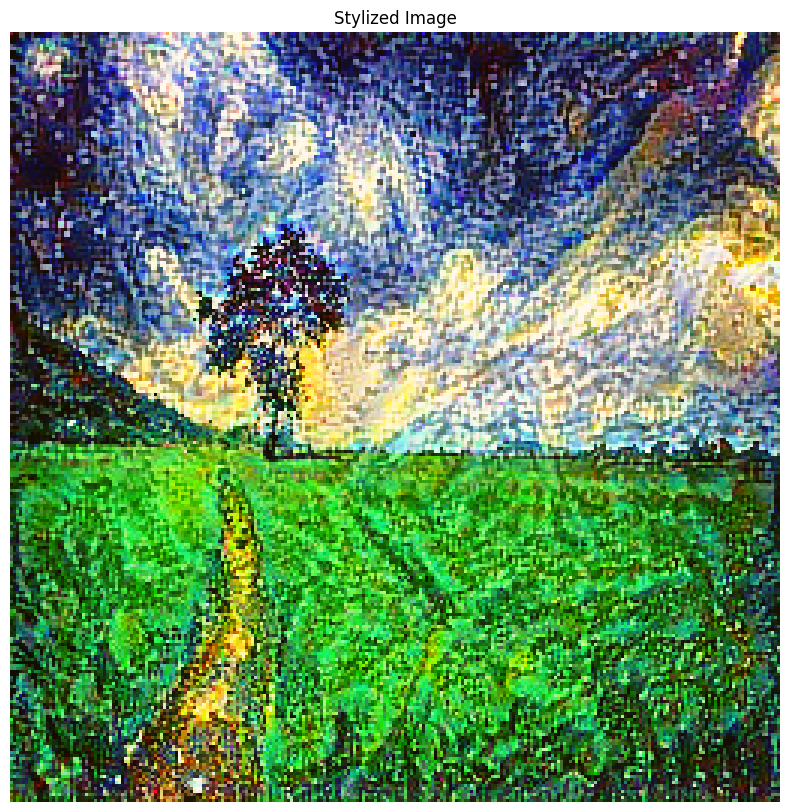

In [4]:
# Load and preprocess images
def load_and_process_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img, dtype=tf.float32)

# Deprocess image
def deprocess_image(img):
    img = img.numpy()
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

# Load VGG19 model
def get_model():
    vgg = VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    content_layers = ['block5_conv2']
    style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
    outputs = [vgg.get_layer(name).output for name in content_layers + style_layers]
    model = Model(inputs=vgg.input, outputs=outputs)
    return model, content_layers, style_layers

# Compute content loss
def compute_content_loss(content_output, combination_output):
    return tf.reduce_mean(tf.square(content_output - combination_output))

# Compute Gram matrix
def gram_matrix(tensor):
    channels = int(tensor.shape[-1])
    vectorized = tf.reshape(tensor, [-1, channels])
    gram = tf.matmul(tf.transpose(vectorized), vectorized)
    return gram / tf.cast(tf.shape(vectorized)[0], tf.float32)

# Compute style loss
def compute_style_loss(style_output, combination_output):
    gram_style = gram_matrix(style_output)
    gram_combination = gram_matrix(combination_output)
    return tf.reduce_mean(tf.square(gram_style - gram_combination))

# Compute total loss
def compute_loss(model, content_image, style_image, combination_image, content_weight, style_weight):
    outputs = model(combination_image)
    content_outputs = outputs[:1]
    style_outputs = outputs[1:]

    content_loss = content_weight * compute_content_loss(content_outputs[0], model(content_image)[0])

    style_loss = 0
    for style_output, target_style in zip(style_outputs, model(style_image)[1:]):
        style_loss += compute_style_loss(target_style, style_output)
    style_loss *= style_weight / len(style_outputs)

    total_loss = content_loss + style_loss
    return total_loss

# Style transfer function
def style_transfer(content_path, style_path, iterations=100, content_weight=1e3, style_weight=1e-2):
    content_image = load_and_process_image(content_path)
    style_image = load_and_process_image(style_path)
    combination_image = tf.Variable(content_image)

    model, _, _ = get_model()
    optimizer = tf.optimizers.Adam(learning_rate=5.0)

    for i in range(iterations):
        with tf.GradientTape() as tape:
            loss = compute_loss(model, content_image, style_image, combination_image, content_weight, style_weight)
        grads = tape.gradient(loss, combination_image)
        optimizer.apply_gradients([(grads, combination_image)])
        combination_image.assign(tf.clip_by_value(combination_image, -103.939, 255.0 - 123.68))

        if i % 10 == 0:
            print(f"Iteration {i}/{iterations}, Loss: {loss.numpy():.4f}")

    final_image = deprocess_image(combination_image)
    return final_image

# Paths to content and style images
content_image_path = "content.jpg"      # path of your content image
style_image_path = "style.jpg"          # path of your artistic style image

# Run style transfer
stylized_image = style_transfer(content_image_path, style_image_path, iterations=100)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(stylized_image)
plt.axis("off")
plt.title("Stylized Image")
plt.show()
